In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import warnings
import optuna
import joblib
import os
import time
from lightgbm import LGBMClassifier
from pandas.api.types import is_numeric_dtype
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
from matplotlib.colors import LinearSegmentedColormap


## NSL KDD dataset
## Source: https://www.kaggle.com/datasets/hassan06/nslkdd¶

In [19]:
features=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "level"]

In [20]:
kdddset = pd.read_csv('/Users/ramejha/Documents/BitsProject/datasets/nslkdd/nsl-kdd/KDDTrain+.txt', names=features)

In [21]:
kdddset.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
9,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


In [22]:
kdddset.shape

(125973, 43)

In [23]:
set(kdddset['attack'].values)

{'back',
 'buffer_overflow',
 'ftp_write',
 'guess_passwd',
 'imap',
 'ipsweep',
 'land',
 'loadmodule',
 'multihop',
 'neptune',
 'nmap',
 'normal',
 'perl',
 'phf',
 'pod',
 'portsweep',
 'rootkit',
 'satan',
 'smurf',
 'spy',
 'teardrop',
 'warezclient',
 'warezmaster'}

In [24]:
kdddset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [25]:
attack_mapping = {
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS',
    'teardrop': 'DoS', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'satan': 'Probe', 'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L',
    'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R'
}

In [26]:
kdddset['attack_group'] = kdddset['attack'].map(attack_mapping).fillna('normal')

In [27]:
set(kdddset['attack_group'].values)

{'DoS', 'Probe', 'R2L', 'U2R', 'normal'}

In [28]:
# 1. Distribution of Numerical Features
kdddset.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


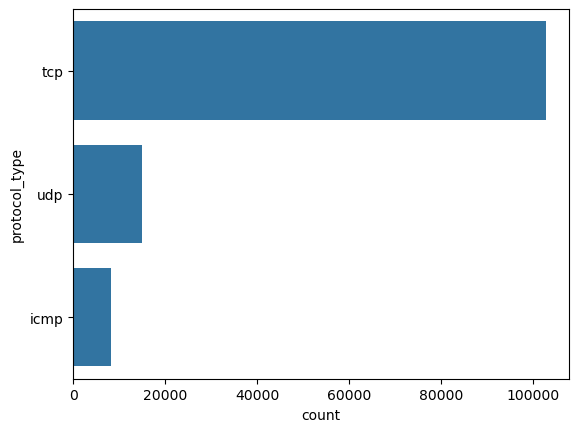

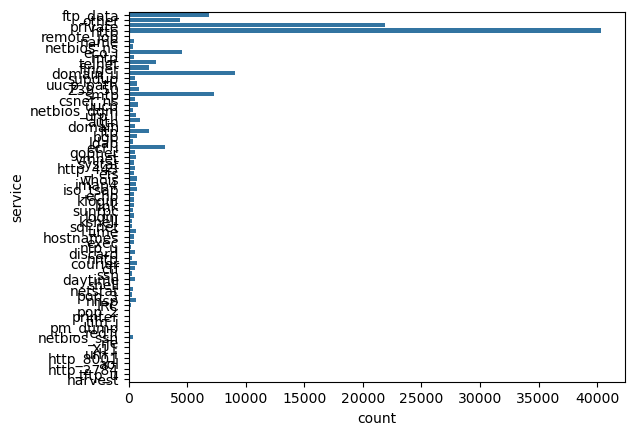

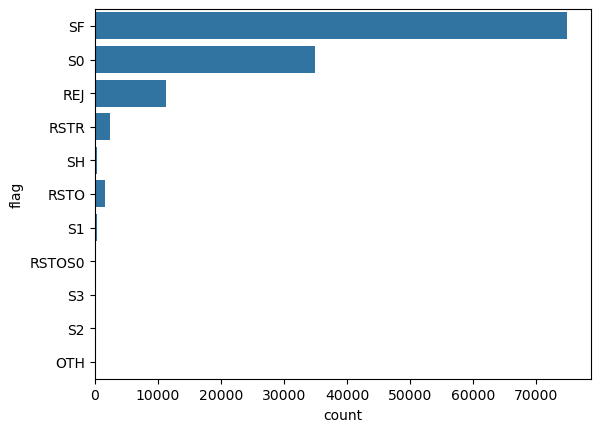

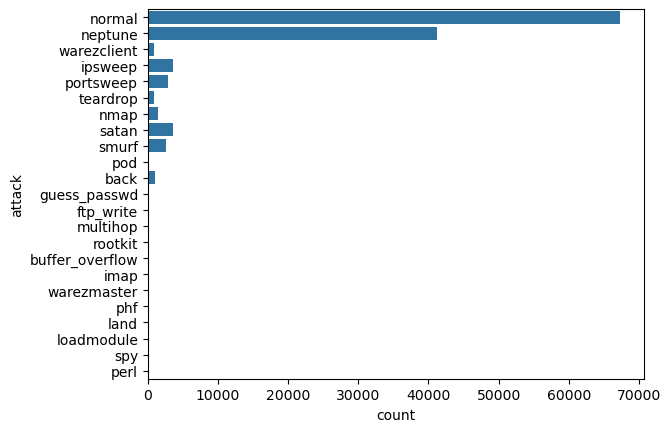

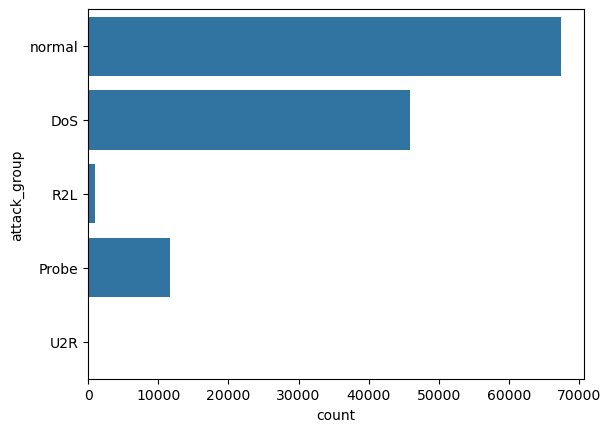

In [29]:
# 2. Distribution of Categorical Features
for col in ['protocol_type', 'service', 'flag', 'attack', 'attack_group']:
    sns.countplot(y=col, data=kdddset)
    plt.show()

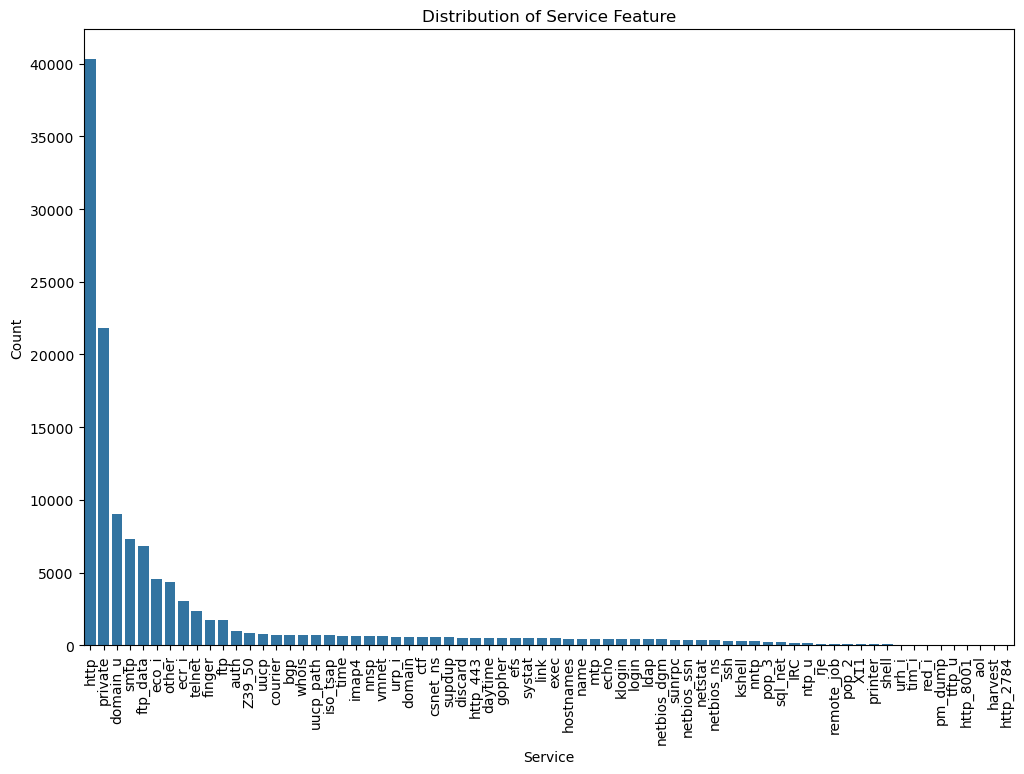

In [30]:
# Plot with rotated x-axis labels
plt.figure(figsize=(12, 8))
sns.countplot(x='service', data=kdddset, order=kdddset['service'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Service')
plt.ylabel('Count')
plt.title('Distribution of Service Feature')
plt.show()

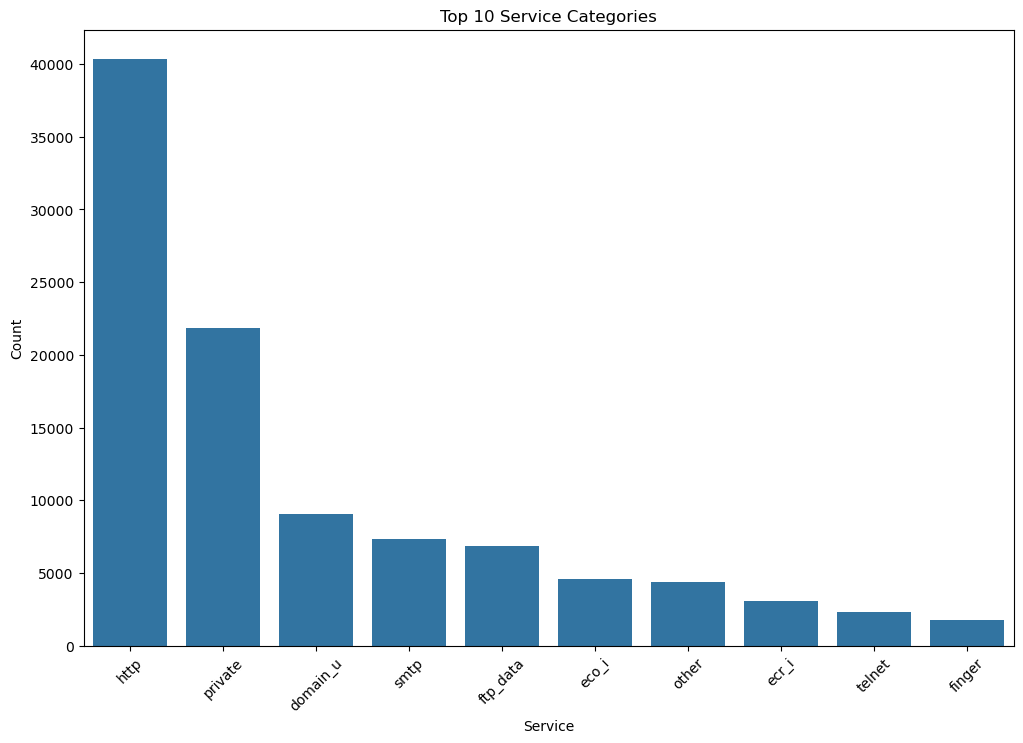

In [31]:
# Plotting only the top N most frequent services
top_n = 10
top_services = kdddset['service'].value_counts().nlargest(top_n).index
plt.figure(figsize=(12, 8))
sns.countplot(x='service', data=kdddset[kdddset['service'].isin(top_services)], order=top_services)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Service')
plt.ylabel('Count')
plt.title(f'Top {top_n} Service Categories')
plt.show()

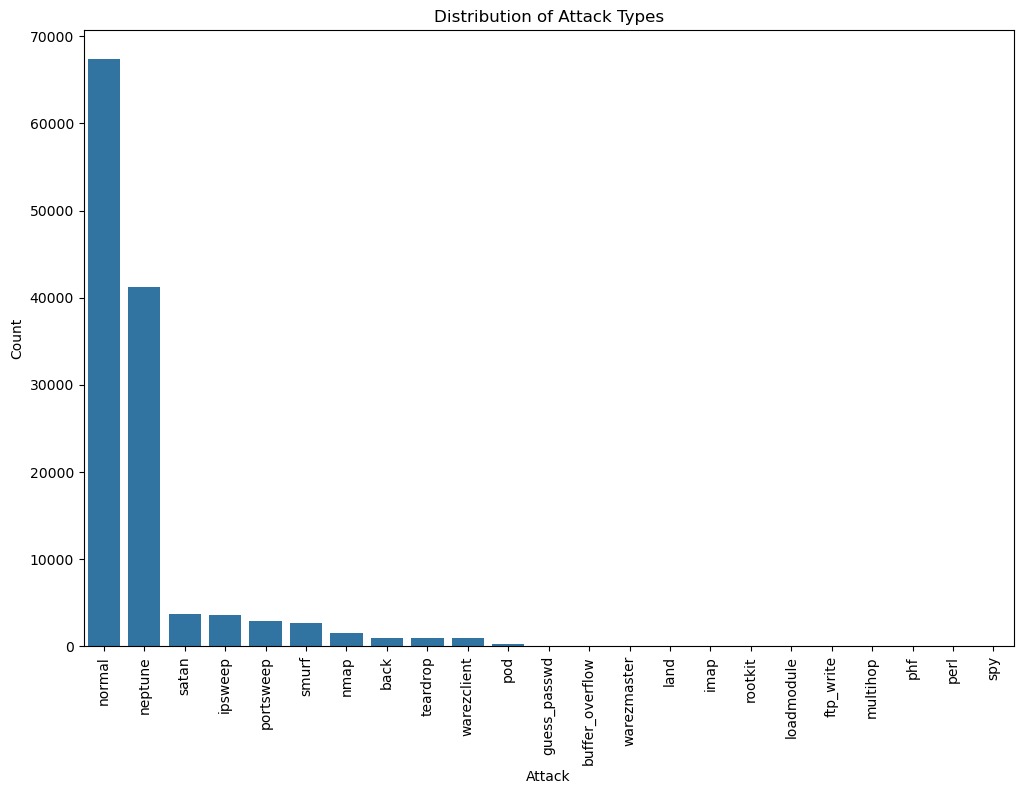

In [32]:
# Plot with rotated x-axis labels
plt.figure(figsize=(12, 8))
sns.countplot(x='attack', data=kdddset, order=kdddset['attack'].value_counts().index)
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Attack')
plt.ylabel('Count')
plt.title('Distribution of Attack Types')
plt.show()

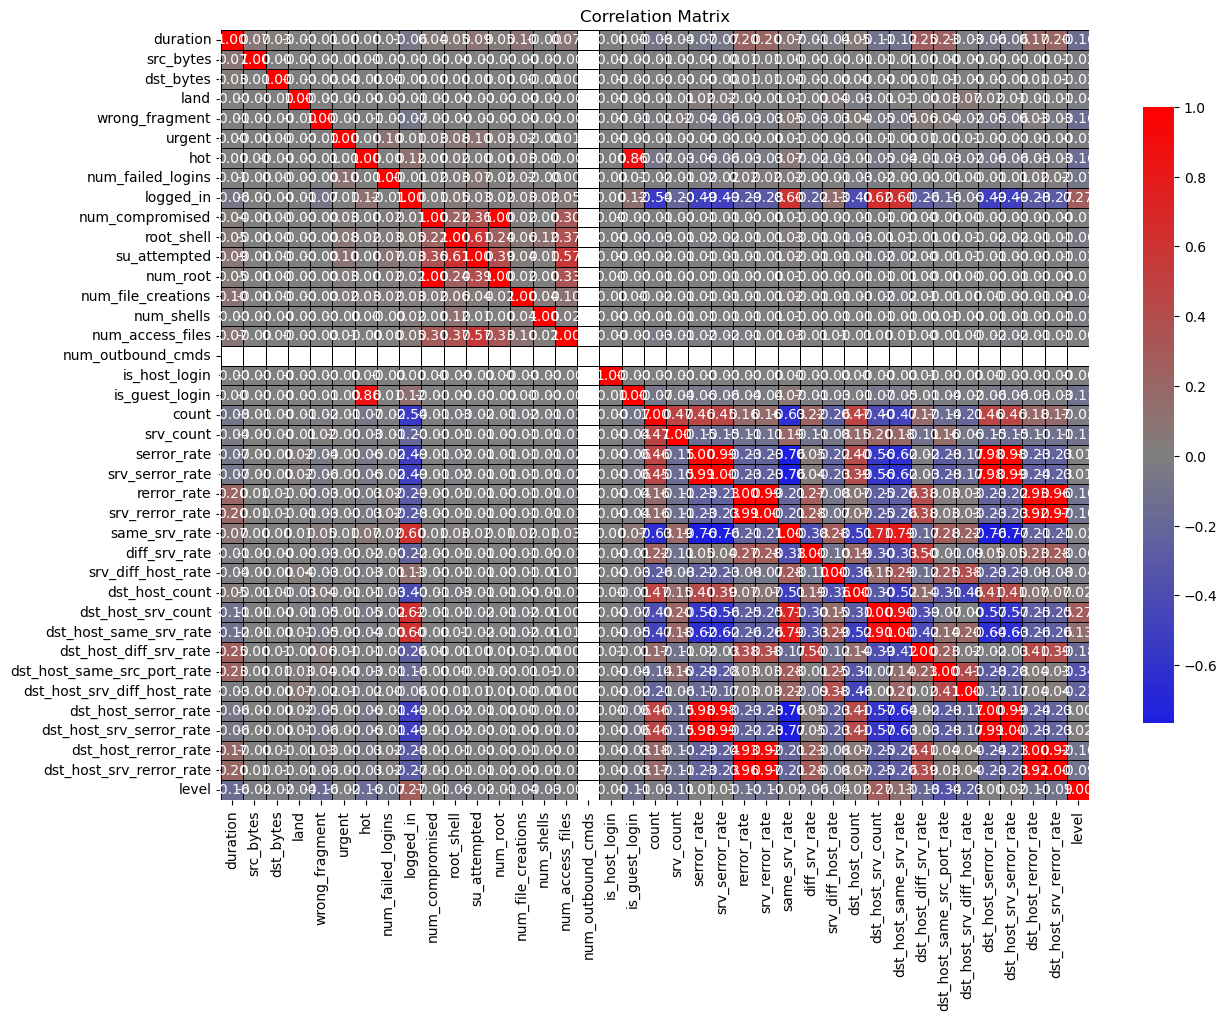

In [33]:
# 3. Correlation Matrix
# Define the custom colormap
colors = ["blue", "grey", "red"]
cmap_name = "red_blue_grey"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


numeric_data = kdddset.drop(columns=['protocol_type', 'service', 'flag', 'attack', 'attack_group'])
correlation = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))  # Increase the size of the plot for readability
sns.heatmap(correlation, annot=True, fmt=".2f", cmap=custom_cmap, center=0, 
            linewidths=.5, linecolor='black', cbar_kws={"shrink": .8})

plt.title('Correlation Matrix')
plt.show()

Importance of each of the 42 fields in the NSL-KDD dataset for detecting intrusions. Each feature's importance will depend on its ability to distinguish between normal and anomalous behavior in the network traffic.

1.	duration: Length of the connection in seconds. Longer durations can sometimes indicate normal activity, but very short or excessively long durations might be suspicious.
2.	protocol_type: Type of protocol (TCP, UDP, ICMP). Certain types of attacks are protocol-specific, so this is important.
3.	service: Network service on the destination (e.g., HTTP, FTP). Some services are more vulnerable to specific attacks, making this a crucial feature.
4.	flag: Status flag of the connection. Indicates the state of the connection, e.g., whether it was successful or reset. Certain flags are indicative of attacks.
5.	src_bytes: Number of data bytes sent from the source to the destination. Unusually high or low values may indicate anomalies.
6.	dst_bytes: Number of data bytes sent from the destination to the source. Similar to src_bytes, anomalies may indicate malicious activity.
7.	land: Binary feature indicating if the connection is to/from the same host/port. It's often used to identify land attacks.
8.	wrong_fragment: Number of wrong fragments. Non-zero values might indicate attacks attempting to bypass detection.
9.	urgent: Number of urgent packets. A higher number of urgent packets can be a sign of malicious activity.
10.	hot: Number of "hot" indicators in the content, like failed logins. A high count can indicate suspicious behavior.
11.	num_failed_logins: Number of failed login attempts. Multiple failed attempts can suggest a brute force attack.
12.	logged_in: Binary feature indicating if the login was successful. Important for distinguishing between successful and failed login attempts.
13.	num_compromised: Number of compromised conditions. A higher number suggests an ongoing attack.
14.	root_shell: Binary feature indicating if a root shell was obtained. Critical for detecting privilege escalation attacks.
15.	su_attempted: Binary feature indicating if an su command was attempted. Important for identifying privilege escalation attempts.
16.	num_root: Number of root accesses. Frequent root access attempts are suspicious.
17.	num_file_creations: Number of file creation operations. Excessive file creations may indicate malware activity.
18.	num_shells: Number of shell prompts invoked. Multiple shells can indicate intrusion.
19.	num_access_files: Number of times files were accessed. High access rates might be indicative of reconnaissance or exploitation.
20.	num_outbound_cmds: Number of outbound commands in an FTP session. Relevant for identifying data exfiltration via FTP.
21.	is_host_login: Binary feature indicating if the login was to the host. Typically less important unless analyzing host-specific attacks.
22.	is_guest_login: Binary feature indicating if the login was as a guest. Guest logins can be indicative of lower privilege access, possibly used for reconnaissance.
23.	count: Number of connections to the same host as the current connection in the past 2 seconds. High counts may indicate scanning or DoS attacks.
24.	srv_count: Number of connections to the same service as the current connection in the past 2 seconds. Similar to count, used to detect service-specific attacks.
25.	serror_rate: % of connections that have SYN errors. High rates may indicate SYN flood attacks.
26.	srv_serror_rate: % of connections that have SYN errors to the same service. Important for detecting service-specific SYN flood attacks.
27.	rerror_rate: % of connections that have REJ errors. High rates may indicate attempts to access closed ports (e.g., port scanning).
28.	srv_rerror_rate: % of connections that have REJ errors to the same service. Service-specific error rates can reveal targeted attacks.
29.	same_srv_rate: % of connections to the same service. High rates might be normal but could indicate attacks targeting a specific service.
30.	diff_srv_rate: % of connections to different services. High rates can suggest scanning or multipoint attacks.
31.	srv_diff_host_rate: % of connections to different hosts. Important for detecting distributed or scanning attacks.
32.	dst_host_count: Number of connections to the same destination host. Useful for identifying targeted attacks.
33.	dst_host_srv_count: Number of connections to the same service on the destination host. Indicates service-specific targeting.
34.	dst_host_same_srv_rate: % of connections to the same service on the destination host. High rates can suggest service-specific attacks.
35.	dst_host_diff_srv_rate: % of connections to different services on the destination host. Similar to diff_srv_rate, but focused on the destination host.
36.	dst_host_same_src_port_rate: % of connections with the same source port. Unusual rates may indicate a port scan or DoS attack.
37.	dst_host_srv_diff_host_rate: % of connections to different hosts on the same service. Relevant for detecting distributed attacks.
38.	dst_host_serror_rate: % of connections that have SYN errors at the destination host. Important for detecting SYN flood attacks.
39.	dst_host_srv_serror_rate: % of connections that have SYN errors to the same service at the destination host. Service-specific SYN flood indicators.
40.	dst_host_rerror_rate: % of connections that have REJ errors at the destination host. High rates might indicate port scanning.
41.	dst_host_srv_rerror_rate: % of connections that have REJ errors to the same service at the destination host. Service-specific rejection errors can indicate focused scanning.
42.	label: The class label indicating whether the connection was normal or a specific type of attack.


## Dropping Features Based on technical analysis along with correlation matrix comparison
1. num_outbound_cmds - has 0 variance
2. is_host_login - less relevant as login attempts are analyzed using other error rates
3. is_guest_login - less relevant as login attempts are analyzed using other error rates
4. num_shells - correlated to root_shells and we can just keep that
5. logged_in - highly correlated with different kinds of error rates
6. num_root - hightly correlated with num_compromised
7. serror_rate: highly correlated with srv_serror_rate
8. rerror_rate: highly correlated with srv_rerror_rate
9. srv_serror_rate: highly correlated with same_srv_rate
10. srv_rerror_rate: highly correlated with dst_host_rerror_rate
11. dst_host_srv_count: highly correlated with dst_host_serror_rate
12. dst_host_same_srv_rate: highly correlated with dst_host_srv_serror_rate
13. dst_host_srv_serror_rate: highly correlated with dst_host_serror_rate
14. dst_host_srv_rerror_rate: highly correlated with dst_host_rerror_rate


In [36]:
# Prepare the list of features to drop based on above analysis
features_to_drop = ['num_outbound_cmds', 'is_host_login', 'is_guest_login', 'num_shells', 'logged_in', 'num_root', 'serror_rate', 'rerror_rate', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate']

In [37]:
kdddset.shape

(125973, 44)

In [38]:
kdddset = kdddset.drop(columns=features_to_drop)

In [39]:
kdddset.shape

(125973, 30)

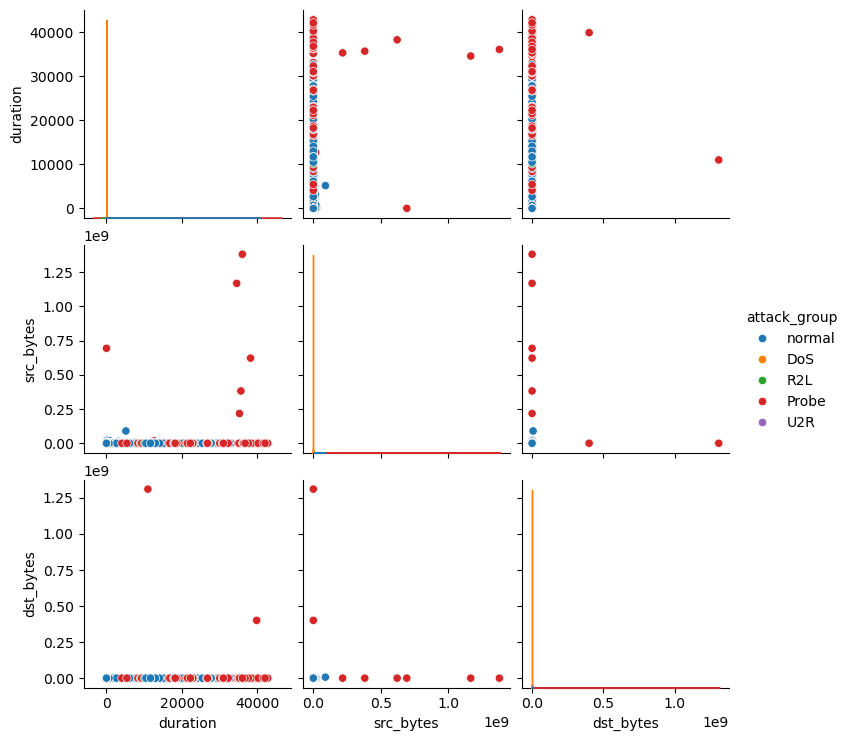

In [40]:
# 6. Pairplot for Feature Interaction
sns.pairplot(kdddset, hue="attack_group", vars=['duration', 'src_bytes', 'dst_bytes'])
plt.show()

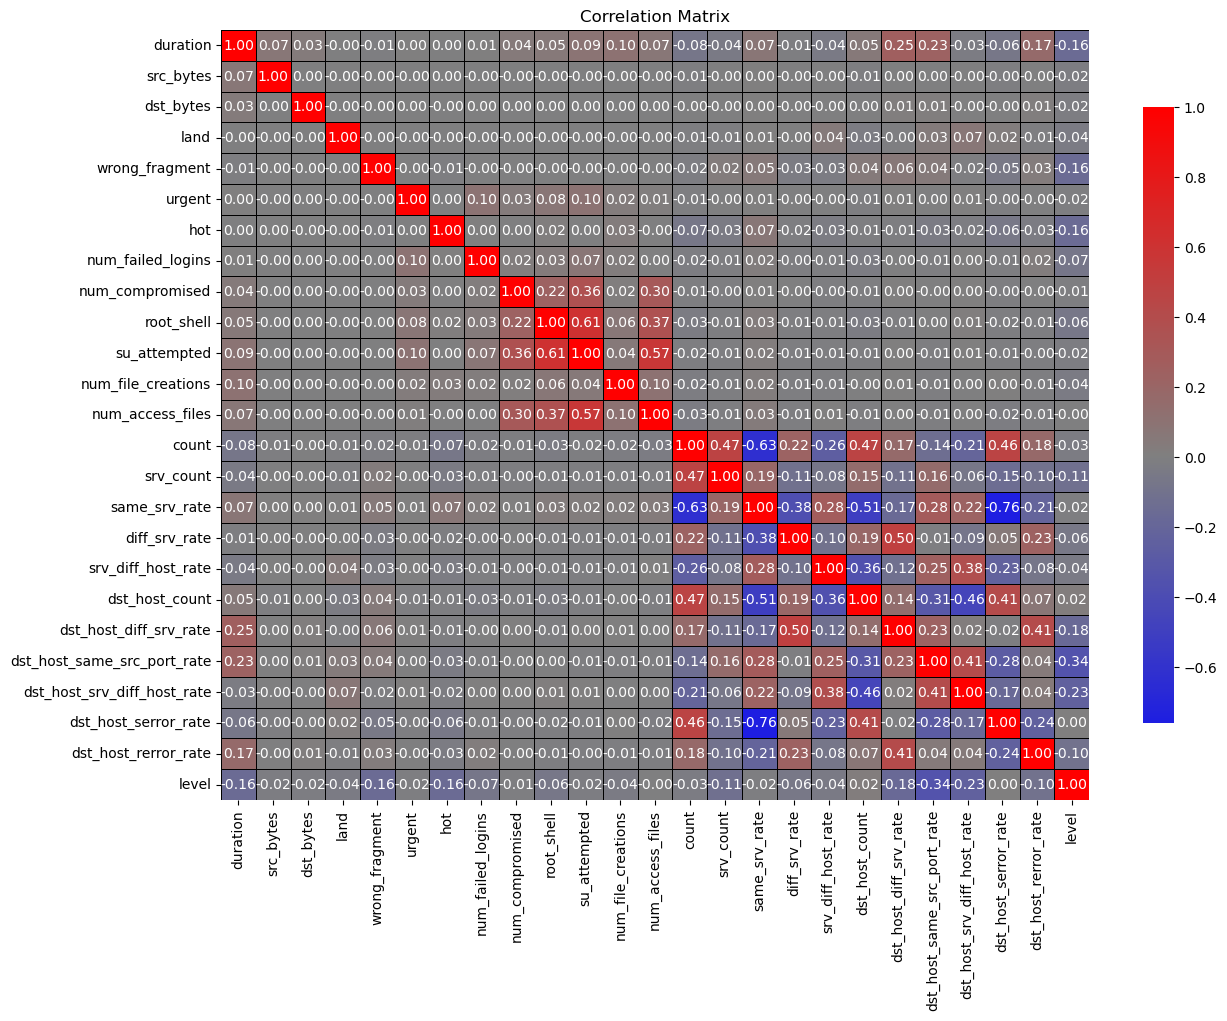

In [41]:
# Define the custom colormap
colors = ["blue", "grey", "red"]
cmap_name = "red_blue_grey"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


numeric_data = kdddset.drop(columns=['protocol_type', 'service', 'flag', 'attack', 'attack_group'])
correlation = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))  # Increase the size of the plot for readability
sns.heatmap(correlation, annot=True, fmt=".2f", cmap=custom_cmap, center=0, 
            linewidths=.5, linecolor='black', cbar_kws={"shrink": .8})

plt.title('Correlation Matrix')
plt.show()

## Principal Component Analysis for further Dimensionality Reduction

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
kdddset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  num_compromised              125973 non-null  int64  
 12  root_shell                   125973 non-null  int64  
 13 

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [46]:
# Label encoding for categorical columns
categorical_columns = ['protocol_type', 'service', 'flag', 'attack', 'attack_group']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    kdddset[col] = le.fit_transform(kdddset[col])
    label_encoders[col] = le

In [47]:
kdddset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,srv_diff_host_rate,dst_host_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,attack,level,attack_group
0,0,1,20,9,491,0,0,0,0,0,...,0.00,150,0.03,0.17,0.00,0.00,0.05,11,20,4
1,0,2,44,9,146,0,0,0,0,0,...,0.00,255,0.60,0.88,0.00,0.00,0.00,11,15,4
2,0,1,49,5,0,0,0,0,0,0,...,0.00,255,0.05,0.00,0.00,1.00,0.00,9,19,0
3,0,1,24,9,232,8153,0,0,0,0,...,0.00,30,0.00,0.03,0.04,0.03,0.00,11,21,4
4,0,1,24,9,199,420,0,0,0,0,...,0.09,255,0.00,0.00,0.00,0.00,0.00,11,21,4


# First verifying attack_group

In [49]:
# Separate Features and Target
X = kdddset.drop(columns=['attack', 'attack_group'])
y = kdddset['attack_group']  # or 'attack' based on your analysis

In [50]:
# Standardize the numerical features to have a mean of 0 and a standard deviation of 1.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [51]:
# Now we can apply PCA

training_accuracy = 0.9 # Retain 90% of variance
pca = PCA(n_components=training_accuracy)  
X_pca = pca.fit_transform(X_scaled)

# Save the scaler and PCA model for later use
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca_model.pkl')

# Check the number of components selected
print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 20


Principal Component 1 (PC1): This is the direction in the data that captures the maximum variance. It is a linear combination of all the original features.

Principal Component 2 (PC2): This is the next direction, orthogonal to PC1, that captures the second-highest variance. It is also a linear combination of the original features.

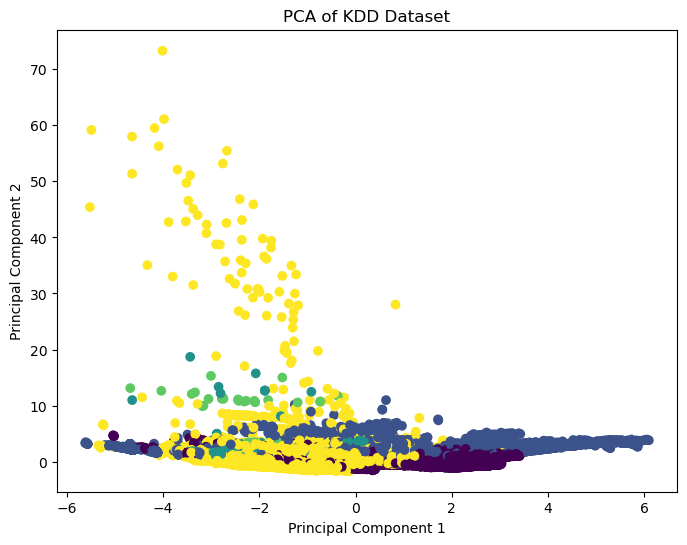

In [53]:
# Visualize PCA Results

# Create a DataFrame for the first two principal components
pca_df = pd.DataFrame(data=X_pca[:, :2], columns=['PC1', 'PC2'])

# Plot the PCA-transformed data
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of KDD Dataset')
plt.show()

In [54]:
# Check variance is captured by each principal component to understand the importance of each component.

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print explained variance
print(f"Explained variance ratio: {explained_variance}")
print(f"Cumulative explained variance: {cumulative_variance}")

Explained variance ratio: [0.14262682 0.08438289 0.08042205 0.06114875 0.05799972 0.04356385
 0.03943886 0.03915203 0.03793596 0.03605352 0.03571622 0.03548243
 0.03522985 0.03280705 0.03215101 0.02870925 0.02579574 0.0234828
 0.02201897 0.02088284]
Cumulative explained variance: [0.14262682 0.2270097  0.30743175 0.36858051 0.42658022 0.47014408
 0.50958293 0.54873496 0.58667092 0.62272444 0.65844066 0.69392309
 0.72915294 0.76195999 0.79411101 0.82282026 0.848616   0.8720988
 0.89411777 0.91500061]


In [55]:
# PCA component loadings (eigenvectors)
loadings = pd.DataFrame(pca.components_, columns=X.columns)
print(loadings)

    duration  protocol_type   service      flag  src_bytes  dst_bytes  \
0   0.005745       0.061807  0.228897 -0.383299  -0.001221   0.000329   
1   0.252306      -0.120108  0.137513 -0.174950   0.018663   0.018899   
2  -0.069948       0.147319 -0.020986  0.161659  -0.008832  -0.010569   
3   0.249336       0.497807 -0.052355  0.168789   0.027994   0.023934   
4  -0.048428      -0.217326 -0.292290  0.025423  -0.002283   0.001604   
5   0.187242       0.017800  0.236501  0.147086   0.094402   0.048075   
6  -0.010250      -0.073426 -0.174686 -0.150545   0.024541   0.009273   
7   0.482181      -0.130935 -0.090654 -0.059810   0.351931   0.167139   
8   0.251652       0.022467  0.186605  0.062383   0.187147   0.103411   
9   0.010254       0.081382 -0.096930 -0.223653   0.458628   0.257853   
10 -0.004238      -0.011391  0.010266 -0.006108  -0.479721   0.873311   
11 -0.052613      -0.086066  0.049805  0.051307   0.360393   0.146769   
12 -0.026035       0.034783 -0.029977  0.207744   0

In [56]:
# Set a threshold for loadings (e.g., 0.1)
threshold = 0.1

# Identify features with low contributions across most components
low_contributing_features = loadings.columns[(loadings.abs() < threshold).all(axis=0)]
print("Features to consider dropping:", low_contributing_features)

Features to consider dropping: Index([], dtype='object')


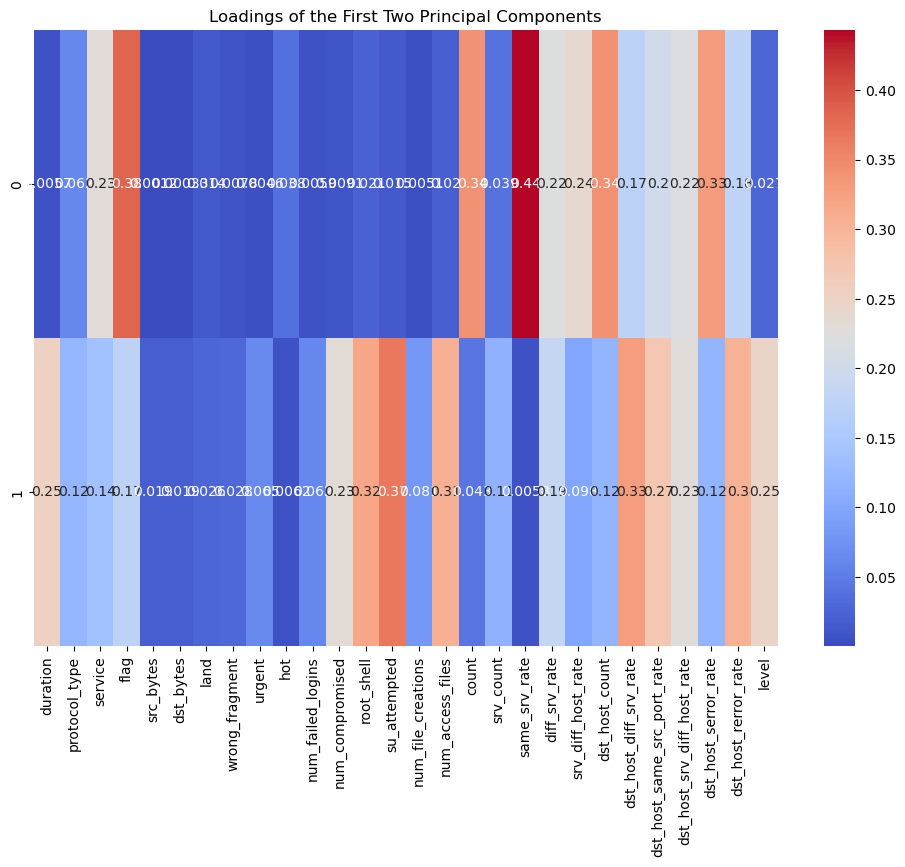

In [57]:
import seaborn as sns

# Visualize the loadings for the first two principal components
plt.figure(figsize=(12, 8))
sns.heatmap(loadings.iloc[:2].abs(), cmap='coolwarm', annot=True, xticklabels=X.columns)
plt.title("Loadings of the First Two Principal Components")
plt.show()

In [58]:
#  Find the Most Contributing Features for PC1 and PC2:
# Assuming 'loadings' is the DataFrame that contains the PCA components
loadings = pd.DataFrame(pca.components_, columns=X.columns)

# Get the features that contribute the most to PC1 and PC2
most_important_features_pc1 = loadings.iloc[0].abs().sort_values(ascending=False).head(5)
most_important_features_pc2 = loadings.iloc[1].abs().sort_values(ascending=False).head(5)

print("Top 5 features contributing to PC1:\n", most_important_features_pc1)
print("Top 5 features contributing to PC2:\n", most_important_features_pc2)

Top 5 features contributing to PC1:
 same_srv_rate           0.443209
flag                    0.383299
dst_host_count          0.342397
count                   0.340436
dst_host_serror_rate    0.329699
Name: 0, dtype: float64
Top 5 features contributing to PC2:
 su_attempted              0.366007
dst_host_diff_srv_rate    0.327739
root_shell                0.317400
num_access_files          0.305395
dst_host_rerror_rate      0.304391
Name: 1, dtype: float64


In [59]:
# Create a DataFrame with the principal components
num_components = X_pca.shape[1]
pca_columns = [f'PC{i+1}' for i in range(num_components)]
pca_df = pd.DataFrame(X_pca, columns=pca_columns)

In [60]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-1.361634,-0.462804,0.294046,0.330646,-0.461852,-0.252048,0.177737,0.159721,-0.063695,0.007863,0.005116,-0.026243,0.086769,-0.128648,0.047310,-0.047935,0.472505,0.356722,-0.239010,0.253276
1,0.599591,1.601378,-1.140861,2.383819,-0.191443,1.438290,-1.166616,-0.788424,0.126889,-1.071469,-0.066424,0.277166,1.304671,-0.403072,-0.117109,-0.155925,1.125085,-0.712688,0.832878,-1.632679
2,2.207460,-0.375036,0.369386,-1.008896,-0.056274,1.015842,-0.329994,0.009180,0.174840,-0.037073,0.027987,0.157695,-0.025194,-0.281552,0.106428,-0.015329,-0.005994,0.023832,0.182078,-0.280433
3,-1.721008,-0.552262,0.345291,-0.188505,-0.809062,-0.439112,0.197629,0.081005,0.006968,0.041532,-0.003368,-0.035591,0.015700,0.038622,-0.031915,-0.033782,0.426915,0.801628,-0.192168,0.102644
4,-0.892542,-0.938393,0.699114,0.403705,-0.283515,-0.400638,0.113556,0.175713,0.083418,-0.048974,0.007023,-0.085694,0.087183,-0.011106,-0.003614,0.019560,-0.217216,-0.028185,-0.188420,0.412419


In [61]:
# Add the target variable back to the DataFrame
pca_df['attack_group'] = y.values  # Or df['attack'] 

In [62]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,attack_group
0,-1.361634,-0.462804,0.294046,0.330646,-0.461852,-0.252048,0.177737,0.159721,-0.063695,0.007863,...,-0.026243,0.086769,-0.128648,0.047310,-0.047935,0.472505,0.356722,-0.239010,0.253276,4
1,0.599591,1.601378,-1.140861,2.383819,-0.191443,1.438290,-1.166616,-0.788424,0.126889,-1.071469,...,0.277166,1.304671,-0.403072,-0.117109,-0.155925,1.125085,-0.712688,0.832878,-1.632679,4
2,2.207460,-0.375036,0.369386,-1.008896,-0.056274,1.015842,-0.329994,0.009180,0.174840,-0.037073,...,0.157695,-0.025194,-0.281552,0.106428,-0.015329,-0.005994,0.023832,0.182078,-0.280433,0
3,-1.721008,-0.552262,0.345291,-0.188505,-0.809062,-0.439112,0.197629,0.081005,0.006968,0.041532,...,-0.035591,0.015700,0.038622,-0.031915,-0.033782,0.426915,0.801628,-0.192168,0.102644,4
4,-0.892542,-0.938393,0.699114,0.403705,-0.283515,-0.400638,0.113556,0.175713,0.083418,-0.048974,...,-0.085694,0.087183,-0.011106,-0.003614,0.019560,-0.217216,-0.028185,-0.188420,0.412419,4


## After PCA, we are now ready to execute basic algorithms as well as targetted algorithms CNN, RNN. We are going to track the performance and classification and plot them for comparison.

In [64]:
# Initialize Lists to Collect Results:
algorithms = ['Random Forest', 'Gradient Boosting', 'Decision Tree', 'kNN', 'CNN', 'RNN']
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
execution_time_list = []

# Random Forest Model

In [66]:
# Step 1: drop target
X = pca_df.drop(columns=['attack_group'])  # PCA features
y = pca_df['attack_group']  # Target column

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Measure execution time
start_time = time.time()

# Initialize and train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Record execution time
execution_time_list.append(time.time() - start_time)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

# Calculate metrics
accuracy_list.append(accuracy_score(y_test, rf_predictions))
precision_list.append(precision_score(y_test, rf_predictions, average='macro'))
recall_list.append(recall_score(y_test, rf_predictions, average='macro'))
f1_list.append(f1_score(y_test, rf_predictions, average='macro'))

Random Forest Accuracy: 0.9980419136325148
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13825
           1       0.99      1.00      1.00      3540
           2       0.98      0.96      0.97       327
           3       0.88      0.41      0.56        17
           4       1.00      1.00      1.00     20083

    accuracy                           1.00     37792
   macro avg       0.97      0.87      0.90     37792
weighted avg       1.00      1.00      1.00     37792



# Gradient Boosting Model

In [68]:
# Step 1: drop target
X = pca_df.drop(columns=['attack_group'])  # PCA features
y = pca_df['attack_group']  # Target column

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Measure execution time
start_time = time.time()

# Initialize and train Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
gb_predictions = gb_model.predict(X_test)

# Record execution time
execution_time_list.append(time.time() - start_time)

# Evaluate the model
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_predictions))
print(classification_report(y_test, gb_predictions))

accuracy_list.append(accuracy_score(y_test, gb_predictions))
precision_list.append(precision_score(y_test, gb_predictions, average='macro'))
recall_list.append(recall_score(y_test, gb_predictions, average='macro'))
f1_list.append(f1_score(y_test, gb_predictions, average='macro'))

Gradient Boosting Accuracy: 0.9909504657070279
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13825
           1       0.97      0.97      0.97      3540
           2       0.93      0.94      0.93       327
           3       0.22      0.47      0.30        17
           4       0.99      0.99      0.99     20083

    accuracy                           0.99     37792
   macro avg       0.82      0.87      0.84     37792
weighted avg       0.99      0.99      0.99     37792



# Decision Tree Model

In [70]:
# Step 1: drop target
X = pca_df.drop(columns=['attack_group'])  # PCA features
y = pca_df['attack_group']  # Target column

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Measure execution time
start_time = time.time()

# Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
dt_predictions = dt_model.predict(X_test)

# Record execution time
execution_time_list.append(time.time() - start_time)

# Evaluate the model
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))

accuracy_list.append(accuracy_score(y_test, dt_predictions))
precision_list.append(precision_score(y_test, dt_predictions, average='macro'))
recall_list.append(recall_score(y_test, dt_predictions, average='macro'))
f1_list.append(f1_score(y_test, dt_predictions, average='macro'))

Decision Tree Accuracy: 0.9949724809483489
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13825
           1       0.98      0.99      0.99      3540
           2       0.94      0.94      0.94       327
           3       0.75      0.53      0.62        17
           4       1.00      1.00      1.00     20083

    accuracy                           0.99     37792
   macro avg       0.93      0.89      0.91     37792
weighted avg       0.99      0.99      0.99     37792



# K Nearest Neighbors (KNN) classification model

In [72]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [73]:
# Step 1: drop target
X = pca_df.drop(columns=['attack_group'])  # PCA features
y = pca_df['attack_group']  # Target column

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Measure execution time
start_time = time.time()

# Step 3: Initialize KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Step 4: Train the KNN model
knn.fit(X_train, y_train)

# Step 5: Make predictions on the test set
knn_pred = knn.predict(X_test)

# Record execution time
execution_time_list.append(time.time() - start_time)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, knn_pred)
print("Accuracy:", accuracy)

# Print detailed evaluation metrics
print(classification_report(y_test, knn_pred))
print(confusion_matrix(y_test, knn_pred))

accuracy_list.append(accuracy_score(y_test, knn_pred))
precision_list.append(precision_score(y_test, knn_pred, average='macro'))
recall_list.append(recall_score(y_test, knn_pred, average='macro'))
f1_list.append(f1_score(y_test, knn_pred, average='macro'))

Accuracy: 0.9975788846993451
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9181
           1       0.99      0.99      0.99      2357
           2       0.97      0.97      0.97       224
           3       0.83      0.45      0.59        11
           4       1.00      1.00      1.00     13422

    accuracy                           1.00     25195
   macro avg       0.96      0.88      0.91     25195
weighted avg       1.00      1.00      1.00     25195

[[ 9171     1     1     0     8]
 [    1  2345     0     0    11]
 [    0     1   218     0     5]
 [    0     1     1     5     4]
 [    7    14     5     1 13395]]


# Convolutional Neural Network (CNN)  

In [75]:
# Reshape data into a 3D format for CNN: (samples, features, 1 channel)
X = pca_df.drop(columns=['attack_group']).values
y = pd.get_dummies(pca_df['attack_group']).values  # One-hot encoding for multi-class classification

# Reshape X for CNN
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Define CNN model

import tensorflow as tf
from tensorflow.keras import layers, models

# Measure execution time
start_time = time.time()

# Define the CNN model
cnnmodel = models.Sequential()

# Add a 1D Convolutional layer
cnnmodel.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add a pooling layer
cnnmodel.add(layers.MaxPooling1D(pool_size=2))

# Add another Convolutional layer (optional)
cnnmodel.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))

# Add a flatten layer to flatten the output
cnnmodel.add(layers.Flatten())

# Add a dense fully connected layer
cnnmodel.add(layers.Dense(128, activation='relu'))

# Add the output layer (number of classes = number of unique attack groups)
cnnmodel.add(layers.Dense(y_train.shape[1], activation='softmax'))

# Compile the model
cnnmodel.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the CNN model
history = cnnmodel.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Get predictions (probabilities)
y_pred_prob = cnnmodel.predict(X_test)

# Record execution time
execution_time_list.append(time.time() - start_time)

# Convert probabilities to class labels
# If it's a multi-class classification problem
y_pred = np.argmax(y_pred_prob, axis=1)

# If y_test is one-hot encoded, convert it back to class labels
# Example: if y_test is [[0, 1], [1, 0]], you need to convert it to [1, 0]
y_test_classes = np.argmax(y_test, axis=1)

# Calculate classification metrics
# Print detailed evaluation metrics
print(classification_report(y_test_classes, y_pred))
print(confusion_matrix(y_test_classes, y_pred))

accuracy_list.append(accuracy_score(y_test_classes, y_pred))
precision_list.append(precision_score(y_test_classes, y_pred, average='macro'))
recall_list.append(recall_score(y_test_classes, y_pred, average='macro'))
f1_list.append(f1_score(y_test_classes, y_pred, average='macro'))



Epoch 1/20


/Users/ramejha/Tools/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9616 - loss: 0.1374 - val_accuracy: 0.9887 - val_loss: 0.0348
Epoch 2/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9915 - loss: 0.0272 - val_accuracy: 0.9924 - val_loss: 0.0242
Epoch 3/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9928 - loss: 0.0215 - val_accuracy: 0.9940 - val_loss: 0.0226
Epoch 4/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9948 - loss: 0.0177 - val_accuracy: 0.9931 - val_loss: 0.0214
Epoch 5/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9945 - loss: 0.0150 - val_accuracy: 0.9939 - val_loss: 0.0183
Epoch 6/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9957 - loss: 0.0123 - val_accuracy: 0.9955 - val_loss: 0.0159
Epoch 7/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9959 - loss: 0.0112 - val_accuracy: 0.9946 - val_loss: 0.0172
Epoch 8/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9963 - loss: 0.0124 - val_accurac

#  Recurrent Neural Network (RNN)

In [77]:
from sklearn.preprocessing import OneHotEncoder

# Prepare features (X) and target (y)
X = pca_df.drop(columns=['attack_group']).values
y = pca_df['attack_group'].values

# Reshape X for RNN (samples, timesteps, features)
X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))  # Use 1 timestep since each sample is independent

# One-hot encode target variable if it's multi-class
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

# Measure execution time
start_time = time.time()

# Build the RNN model
rnnmodel = models.Sequential()
rnnmodel.add(layers.SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
rnnmodel.add(layers.Dense(64, activation='relu'))
rnnmodel.add(layers.Dense(y_train.shape[1], activation='softmax'))

# Compile the model
rnnmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = rnnmodel.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print('Test accuracy:', test_acc)

# Predict and evaluate
y_pred_prob = rnnmodel.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Record execution time
execution_time_list.append(time.time() - start_time)

# Print classification report and confusion matrix
# print(classification_report(y_true_classes, y_pred_classes))
# print(confusion_matrix(y_true_classes, y_pred_classes))

# Calculate classification metrics
# Print detailed evaluation metrics
print(classification_report(y_test_classes, y_pred))
print(confusion_matrix(y_test_classes, y_pred))

accuracy_list.append(accuracy_score(y_test_classes, y_pred))
precision_list.append(precision_score(y_test_classes, y_pred, average='macro'))
recall_list.append(recall_score(y_test_classes, y_pred, average='macro'))
f1_list.append(f1_score(y_test_classes, y_pred, average='macro'))


Epoch 1/20


/Users/ramejha/Tools/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 534us/step - accuracy: 0.9582 - loss: 0.1566 - val_accuracy: 0.9918 - val_loss: 0.0326
Epoch 2/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 518us/step - accuracy: 0.9921 - loss: 0.0278 - val_accuracy: 0.9935 - val_loss: 0.0265
Epoch 3/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 502us/step - accuracy: 0.9939 - loss: 0.0197 - val_accuracy: 0.9932 - val_loss: 0.0263
Epoch 4/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 505us/step - accuracy: 0.9944 - loss: 0.0156 - val_accuracy: 0.9941 - val_loss: 0.0209
Epoch 5/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 493us/step - accuracy: 0.9952 - loss: 0.0146 - val_accuracy: 0.9947 - val_loss: 0.0186
Epoch 6/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 526us/step - accuracy: 0.9955 - loss: 0.0135 - val_accuracy: 0.9953 - val_loss: 0.0180
Epoch 7/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 520us/step - accuracy: 0.9953 - loss: 0.0133 - val_accuracy: 0.9948 - val_loss: 0.0213
Epoch 8/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2s 514us/step - accuracy: 0.9955 - loss: 0.01

# Plot the Metrics:

In [79]:
# Create a DataFrame for easier plotting
results_df = pd.DataFrame({
    'Algorithm': algorithms,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

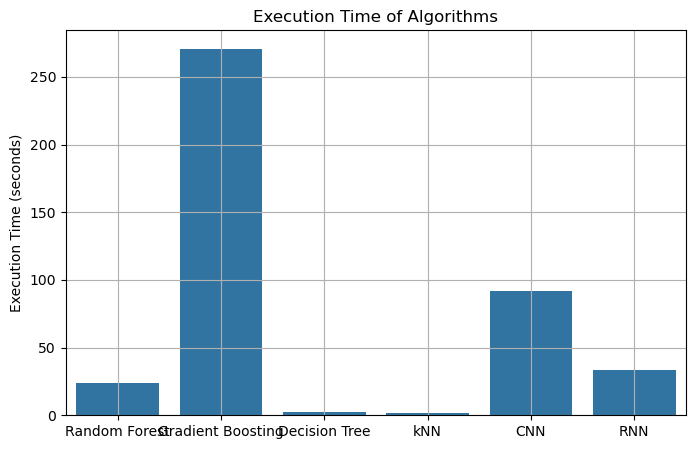

In [80]:
# Plot execution time
plt.figure(figsize=(8, 5))
sns.barplot(x=algorithms, y=execution_time_list)
plt.title('Execution Time of Algorithms')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

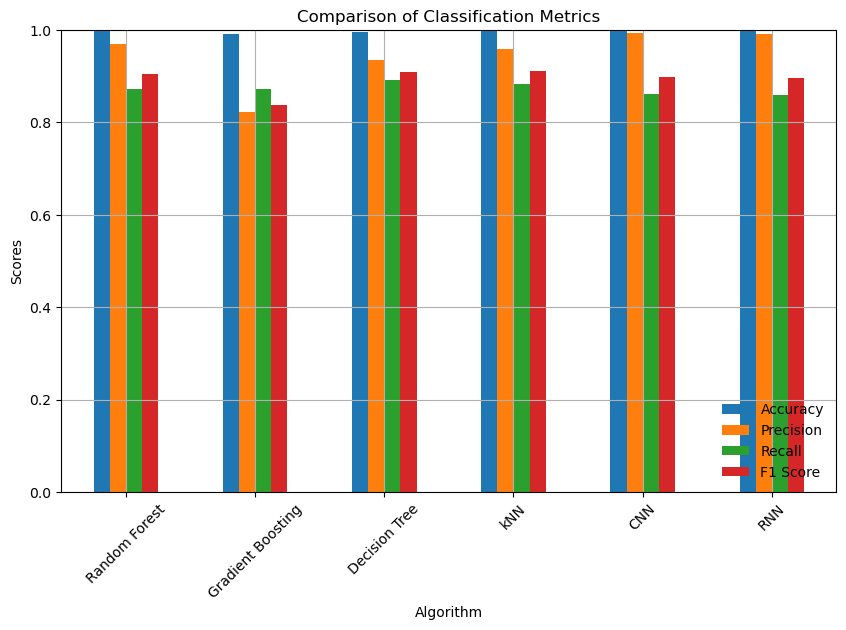

In [81]:
# Plot classification metrics
results_df.set_index('Algorithm').plot(kind='bar', figsize=(10, 6), ylim=(0, 1))
# Adjust the legend position to bottom right
plt.legend(loc='lower right', bbox_to_anchor=(1, 0), frameon=False)  # Adjust as per your preference

plt.title('Comparison of Classification Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Precision:** Important when the cost of false positives (normal traffic being classified as an attack) is high.

**Recall (Sensitivity):** Important when it's crucial to catch as many intrusions as possible (minimizing false negatives).

**F1-Score:** A balanced metric combining precision and recall, especially useful if dataset is imbalanced.

**Accuracy:** Good for overall performance but less informative for imbalanced datasets.

**Execution Time:** Important if real-time performance is a consideration.

# Check Overfitting

In [84]:
nslkddtestset = pd.read_csv('/Users/ramejha/Documents/BitsProject/datasets/nslkdd/nsl-kdd/KDDTest+.txt', names=features)

In [85]:
nslkddtestset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [86]:
nslkddtestset['attack_group'] = nslkddtestset['attack'].map(attack_mapping).fillna('normal')

In [87]:
nslkddtestset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_group
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,DoS
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,DoS
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15,normal
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11,normal


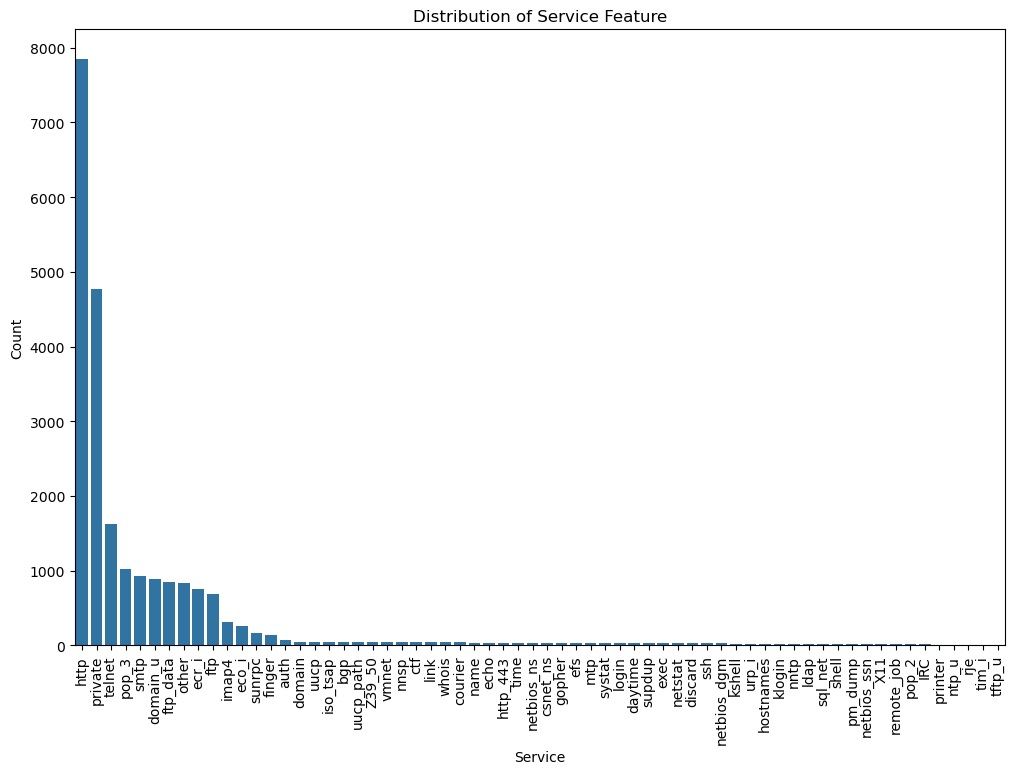

In [88]:
# Plot with rotated x-axis labels
plt.figure(figsize=(12, 8))
sns.countplot(x='service', data=nslkddtestset, order=nslkddtestset['service'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Service')
plt.ylabel('Count')
plt.title('Distribution of Service Feature')
plt.show()

In [89]:
# Prepare the list of features to drop based on above analysis
nslkddtestset = nslkddtestset.drop(columns=features_to_drop)

In [90]:
nslkddtestset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,srv_diff_host_rate,dst_host_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,attack,level,attack_group
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,255,0.06,0.00,0.00,0.0,1.00,neptune,21,DoS
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,255,0.06,0.00,0.00,0.0,1.00,neptune,21,DoS
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.00,134,0.04,0.61,0.02,0.0,0.00,normal,21,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,3,0.00,1.00,0.28,0.0,0.00,saint,15,normal
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.75,29,0.17,0.03,0.02,0.0,0.83,mscan,11,normal


In [91]:
# Label encoding for categorical columns
categorical_columns = ['protocol_type', 'service', 'flag', 'attack', 'attack_group']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    nslkddtestset[col] = le.fit_transform(nslkddtestset[col])
    label_encoders[col] = le

In [92]:
nslkddtestset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,srv_diff_host_rate,dst_host_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,attack,level,attack_group
0,0,1,45,1,0,0,0,0,0,0,...,0.00,255,0.06,0.00,0.00,0.0,1.00,14,21,0
1,0,1,45,1,0,0,0,0,0,0,...,0.00,255,0.06,0.00,0.00,0.0,1.00,14,21,0
2,2,1,19,9,12983,0,0,0,0,0,...,0.00,134,0.04,0.61,0.02,0.0,0.00,16,21,4
3,0,0,13,9,20,0,0,0,0,0,...,1.00,3,0.00,1.00,0.28,0.0,0.00,24,15,4
4,1,1,55,2,0,15,0,0,0,0,...,0.75,29,0.17,0.03,0.02,0.0,0.83,11,11,4


# PCA for test dataset

In [94]:
# Separate Features and Target
X_test = nslkddtestset.drop(columns=['attack', 'attack_group'])
y_test = nslkddtestset['attack_group']  # or 'attack' based on your analysis

In [95]:
# Load the saved scaler and PCA model
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca_model.pkl')

In [158]:
#X_test_pca = pca.fit_transform(X_test_scaled)

# Scale the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Apply the same PCA transformation
X_test_pca = pca.transform(X_test_scaled)  # This will now have the same number of components as the training data


# Random Forest Model

In [161]:
# Load the trained model
# rf_model = joblib.load('rf_model.pkl')

# Make predictions on the test data
y_pred = rf_model.predict(X_test_pca)

/Users/ramejha/Tools/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.8291
Training Accuracy: 0.9980


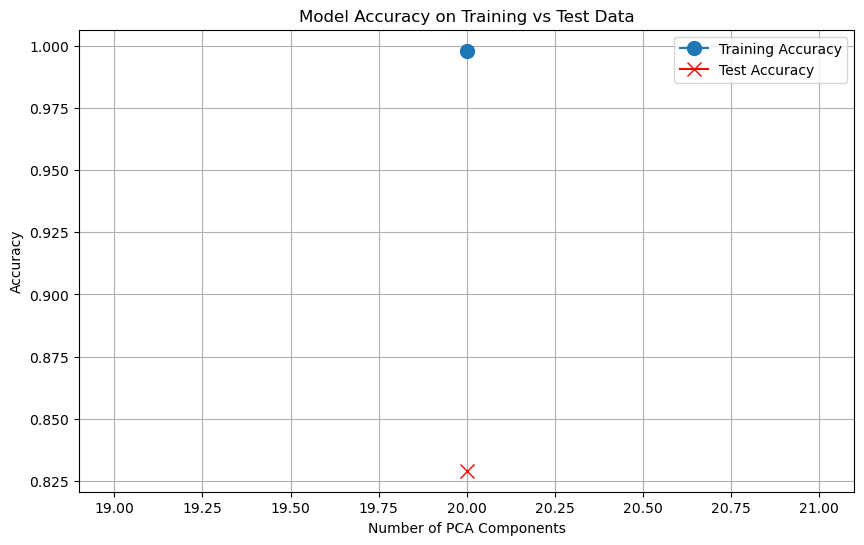

Possible overfitting detected.


In [165]:
# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Training Accuracy: {results_df['Accuracy'].iloc[0]:.4f}')

# Plot the training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot([20], [results_df['Accuracy'].iloc[0]], label='Training Accuracy', marker='o', markersize=10)
plt.plot([20], [test_accuracy], label='Test Accuracy', marker='x', markersize=10, color='red')

plt.title('Model Accuracy on Training vs Test Data')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Check for overfitting
if test_accuracy < training_accuracy:
    print("Possible overfitting detected.")
else:
    print("No overfitting detected.")

# Gradient Boosting Model

Test Accuracy: 0.8199
Training Accuracy: 0.9910


/Users/ramejha/Tools/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


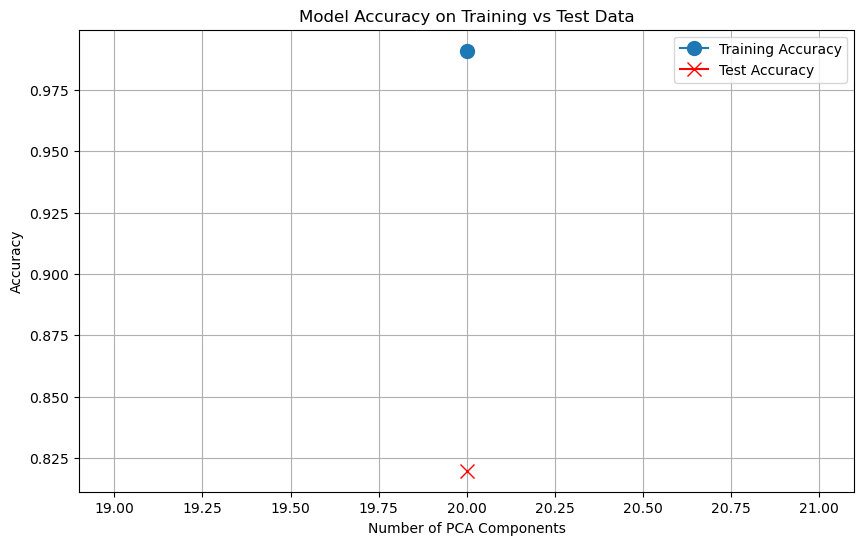

Possible overfitting detected.


In [167]:
# Make predictions on the test data
y_pred = gb_model.predict(X_test_pca)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Training Accuracy: {results_df['Accuracy'].iloc[1]:.4f}')

# Plot the training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot([20], [results_df['Accuracy'].iloc[1]], label='Training Accuracy', marker='o', markersize=10)
plt.plot([20], [test_accuracy], label='Test Accuracy', marker='x', markersize=10, color='red')

plt.title('Model Accuracy on Training vs Test Data')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Check for overfitting
if test_accuracy < training_accuracy:
    print("Possible overfitting detected.")
else:
    print("No overfitting detected.")

# Decision Tree Model¶

Test Accuracy: 0.8130
Training Accuracy: 0.9950


/Users/ramejha/Tools/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


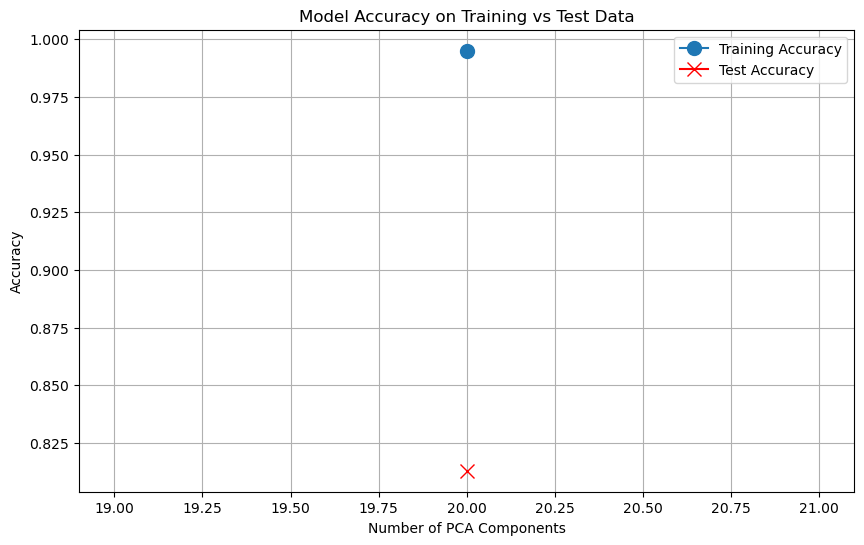

Possible overfitting detected.


In [169]:
# Make predictions on the test data
y_pred = dt_model.predict(X_test_pca)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Training Accuracy: {results_df['Accuracy'].iloc[2]:.4f}')

# Plot the training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot([20], [results_df['Accuracy'].iloc[2]], label='Training Accuracy', marker='o', markersize=10)
plt.plot([20], [test_accuracy], label='Test Accuracy', marker='x', markersize=10, color='red')

plt.title('Model Accuracy on Training vs Test Data')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Check for overfitting
if test_accuracy < training_accuracy:
    print("Possible overfitting detected.")
else:
    print("No overfitting detected.")

# K Nearest Neighbors (KNN) classification model

/Users/ramejha/Tools/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.8036
Training Accuracy: 0.9976


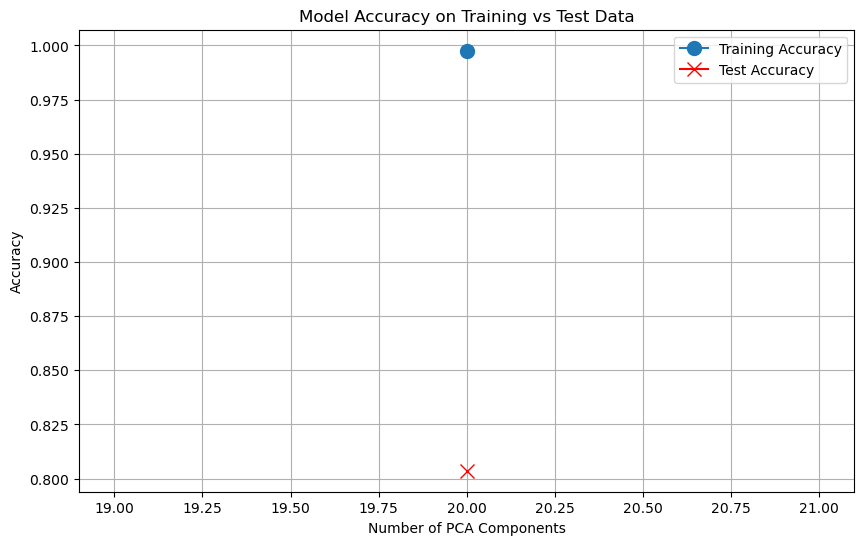

Possible overfitting detected.


In [173]:
# Make predictions on the test data
y_pred = knn.predict(X_test_pca)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Training Accuracy: {results_df['Accuracy'].iloc[3]:.4f}')

# Plot the training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot([20], [results_df['Accuracy'].iloc[3]], label='Training Accuracy', marker='o', markersize=10)
plt.plot([20], [test_accuracy], label='Test Accuracy', marker='x', markersize=10, color='red')

plt.title('Model Accuracy on Training vs Test Data')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Check for overfitting
if test_accuracy < training_accuracy:
    print("Possible overfitting detected.")
else:
    print("No overfitting detected.")

# Convolutional Neural Network (CNN)

705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
Test Accuracy: 0.8056
Training Accuracy: 0.9974


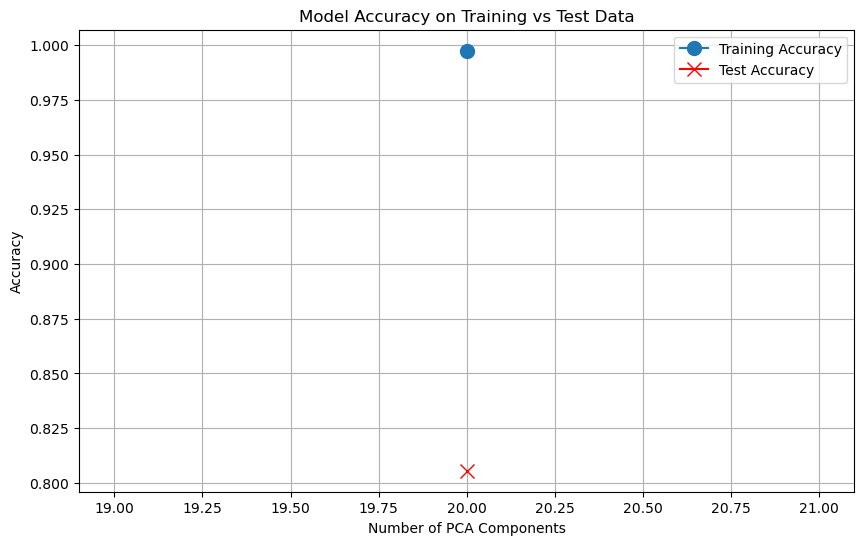

Possible overfitting detected.


In [175]:
# Reshape for CNN input if necessary
# CNNs typically require a 4D tensor (batch_size, height, width, channels)
# If using fully connected layers, reshape to 2D tensor (batch_size, features)
# X_test_pca = X_test_pca.reshape((X_test_pca.shape[0], -1))  # Adjust shape as needed
X_test_pca_cnn = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))

# Make predictions on the test data
y_pred_prob = cnnmodel.predict(X_test_pca_cnn)

# Convert probabilities to class labels
# If it's a multi-class classification problem
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Training Accuracy: {results_df['Accuracy'].iloc[4]:.4f}')

# Plot the training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot([20], [results_df['Accuracy'].iloc[4]], label='Training Accuracy', marker='o', markersize=10)
plt.plot([20], [test_accuracy], label='Test Accuracy', marker='x', markersize=10, color='red')

plt.title('Model Accuracy on Training vs Test Data')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Check for overfitting
if test_accuracy < training_accuracy:
    print("Possible overfitting detected.")
else:
    print("No overfitting detected.")

# Recurrent Neural Network (RNN)¶

705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
Test Accuracy: 0.8057
Training Accuracy: 0.9971


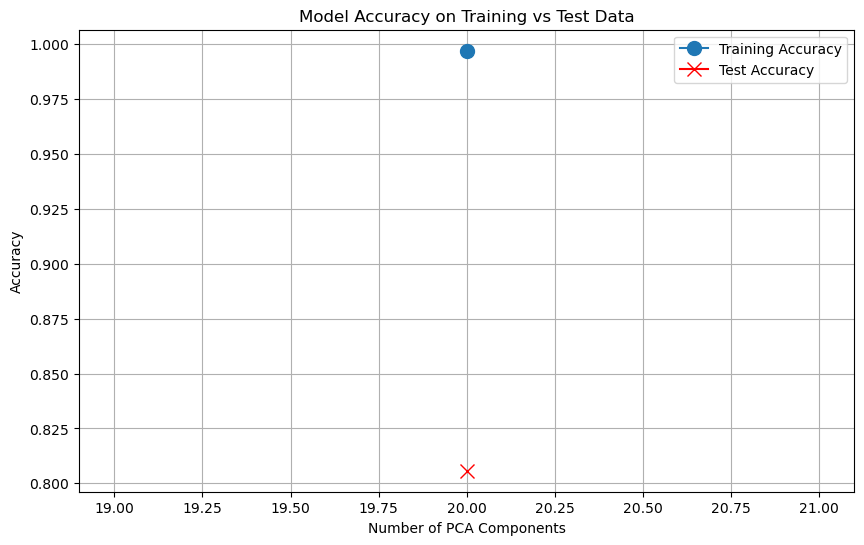

Possible overfitting detected.


In [177]:
#RNN models typically expect sequential data, but since we're using the NSL-KDD dataset, which is tabular, 
#the data needs to be transformed appropriately. we can treat the features as a time series by splitting 
#them into sequences if necessary, but typically for NSL-KDD, we'd reshape 
#the input into a 3D tensor: (samples, timesteps, features)

# Reshape X for RNN (samples, timesteps, features)
X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))  # Use 1 timestep since each sample is independent

X_test_pca_rnn = X_test_pca.reshape((X_test_pca.shape[0], 1, X_test_pca.shape[1]))

# Make predictions on the test data
y_pred_prob = rnnmodel.predict(X_test_pca_rnn)

# Convert probabilities to class labels
# If it's a multi-class classification problem
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Training Accuracy: {results_df['Accuracy'].iloc[5]:.4f}')

# Plot the training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot([20], [results_df['Accuracy'].iloc[5]], label='Training Accuracy', marker='o', markersize=10)
plt.plot([20], [test_accuracy], label='Test Accuracy', marker='x', markersize=10, color='red')

plt.title('Model Accuracy on Training vs Test Data')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Check for overfitting
if test_accuracy < training_accuracy:
    print("Possible overfitting detected.")
else:
    print("No overfitting detected.")
    
